The KL divergence between the posterior distribution $p\left(z\middle|x\right)$, which we want to know, and the approximation to the posterior, $q\left(z\right)$, is defined as $$ \text{KL}\left( q\left(z\right) \left\lVert \, p\left(z \middle| x\right) \right. \right) = \mathbb{E}_q \left[ \log q\left(z\right)\right] - \mathbb{E}_q \left[ \log p\left(z\middle|x\right)\right]  $$

Starting out, we don't actually know the posterior, so we want to rewrite this without that distribution. Recall that

$$ p\left(z\middle|x\right) = \frac{p\left(z,x\right)}{p\left(x\right)}$$

so that we have 

\begin{align} \text{KL}\left( q\left(z\right) \left\lVert \, p\left(z \middle| x\right) \right. \right) & = \mathbb{E}_q \left[ \log q\left(z\right)\right] - \mathbb{E}_q \left[ \log p\left(z,x\right)\right] + \mathbb{E}_q \left[ \log p\left(x\right) \right] \\ & = \mathbb{E}_q \left[ \log q\left(z\right)\right] - \mathbb{E}_q \left[ \log p\left(z,x\right)\right] + \log p\left(x\right)
 \end{align}

where the expectation in the last term is trivial, since the argument doesn't depend on $z$.

The rightmost term involves the evidence, $p\left(x\right)$, which is generally difficult or impossible to calculate (that's what makes Bayesian inference hard!). However, from the point of view of an approximation $q\left(z\right)$, this term is a constant. We will focus instead on the quantity

\begin{align} \text{ELBO}\left(q\right) & = - \text{KL}\left( q\left(z\right) \left\lVert \, p\left(z \middle| x\right) \right. \right) +  \mathbb{E}_q \left[ \log p\left(x\right) \right] \\ & = \mathbb{E}_q \left[ \log p\left(z, x\right)\right] - \mathbb{E}_q \left[ \log q\left(z\right)\right] \end{align}



If we factor the joint distribution in the first term in the other direction --- $p\left(z,x\right) = p\left(z\right)p\left(x\middle|z\right)$ --- then we can see that due to the non-negativity of the KL divergence the ELBO bounds the evidence below, hence the name Evidence Lower BOund.

Since the ELBO is the negative of the KL divergence plus a constant, minimizing the KL divergence is equivalent to maximizing the ELBO.

**Goal**: given some parametric family $\mathcal{D}$ of approximate distributions $q$, find the best approximation $q\left(z\right)$ to the posterior $p\left(z\middle| x\right)$ in the sense that the ELBO is maximized.

### Mean-field family

The mean-field variational family is one such family $\mathcal{D}$ of approximations $q$. They assume independence between the latent variables, so that $$ q\left(z\right) = \prod_{j=1}^m q_j\left(z_j\right)$$ where each $q_j$ is a distribution with its own parameters.

This family is conceptually simple, but does not capture any correlation between variables, which can be a pretty big limitation.

## Algorithm 1: CAVI

A particularly simple algorithm for performing the optimization is to just do ascent on each latent variable coordinate in sequence. 

For example, consider the mean-field family, above, for a problem with $m$ latent variables. First, we will treat variables $z_2,z_3,\ldots,z_m$ and their associated mean-field factors $q_2,q_3,\ldots,q_m$ as fixed and consider optimizing $\text{ELBO}\left(q\right)$ with respect to only the first factor: $\text{ELBO}\left(q\right) = \text{ELBO}\left(q_1\right)$.

If we write this out for arbitrary factor $j$, then we have

\begin{align} \text{ELBO}\left(q_j\right) & = \mathbb{E}_j \left[ \mathbb{E}_{-j} \left[ \log p\left(z_j, z_{-j}, x\right)\right]\right] - \mathbb{E}_j\left[ \log q_j\left(z_j\right) \right] + \text{const.} \\ & = - \text{KL}\left(\log q_j\left(z_j\right) \lVert \, \mathbb{E}_{-j} \left[ \log p\left(z_j, z_{-j}, x\right)\right] \right) + \text{const.}  \end{align}

where we have written the ELBO (as a function of only one factor) as a negative KL divergence between that factor and another distribution, plus an additive constant. Again, to maximize the ELBO we can minimize the negative KL divergence, which in this case will be minimized when we take $$ \log q_j\left(z_j\right) = \mathbb{E}_{-j} \left[ \log p\left(z_j, z_{-j}, x\right) \right] $$

### Aside 

Note that the KL divergence is computed between two distributions, *not* between two scalars. When writing the KLD between two distributions, we have written out the random variables as "arguments" to the distributions, but this was misleading. It should really have been written $$ \text{KL}\left(q \left\lVert  \, p \right. \right)$$ but this is misleading for other reasons: we have multiple distributions "named" $p$. The KLD is defined in terms of expected values of distributions, and so what comes out of it should be a number.

Thus, to minimize the ELBO, we set the two function in the KLD equal to each other. This means that for every possible value of $z_j$, we have $$ \log q_j \left(z_j\right) = \mathbb{E}_{-j}\left[ \log p\left(z_j, z_{-j}, x\right)\right] $$ or $$ q_j\left(z_j\right) = \exp \left\{ \mathbb{E}_{-j}\left[ \log p\left(z_j, z_{-j}, x\right)\right] \right\} $$ where the expectations are taken over the fixed variational density $$ \prod_{l \neq j} q_l\left(z_l\right)$$ over $z_{-j}$. Finally, we can once again apply the definition of conditional probability to get $$ q_j \left(z_j\right) \propto \exp\left\{\mathbb{E}_{-j}\left[ \log p\left(z_j\, \middle| \, z_{-j}, x\right)\right] \right\}. $$

The distribution on the right is called the *complete conditional of $z_j$*. It is the conditional distribution of $z_j$ given all other variables in the model.

What does this all mean? It means that if we consider all but one variational factor fixed, we can optimize the ELBO with respect to that unfixed factor by setting it equal to (or proportional to) that function of $z_j$ defined on the right-hand side.

### Example: CAVI

Consider a mixture of two Gaussian distributions.

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

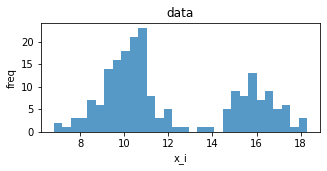

In [2]:
# instantiate parameters
mu = np.array([10.0, 16.0])     # [mu_0, mu_1]
sigma2 = 2.0
p = 0.35                        # p(c_i = 1)
n = 200

# generate data
c_i = ss.bernoulli(p=p).rvs(size=n)
x_i = [ss.norm(loc=mu[c], scale=1.0).rvs() for c in c_i]

_, ax = plt.subplots(figsize=(5,2))
ax.hist(x_i, bins=30, color='tab:blue', alpha=0.75)
ax.set(xlabel='x_i', ylabel='freq', title="data")
plt.show()

The full joint density is

\begin{align*}
p\left(\mu_{0:1}, c_{1:n}, x_{1:n}\right) & = p\left(\mu_{0:1}\right) \prod_{i=1}^n p\left(c_i\right) p\left(x_i \, \middle| \, \, c_i, \mu_{0:1}\right)
\end{align*}

I think we will need to calculate, by hand, the complete conditional of each of the latent variables. So what are each of the distributions here?

What is the (full) ELBO for this problem? The variational parameters are $m$, $s^2$, and $\varphi$. Hence, $q$ is always (at least implicitly) a function of these parameters.

The full joint distribution $p\left(z,x\right)$ is our model, written above; the variational distribution $q\left(z\right)$ is our mean-field distribution over all latent variables in the model: $\mu_0, \mu_1$, and $c_i$ for all observations $i=1,2,\ldots,n$. It looks like

\begin{align*}
    q\left(z\right) = q\left(z \, ; \, m, s^2, \varphi \right) & = q\left( \mu_0 \, ; \, m_0, s_0^2\right)q\left( \mu_1 \, ; \, m_1, s_1^2\right) \left( \prod_{i=1}^n q\left(c_i \, ; \, \varphi_i \right) \right) \\
    & = q\left( \mu_0 \right)q\left( \mu_1 \right) \prod_{i=1}^n q\left(c_i \right) \\
\end{align*}

The notation here might be confusing. Each factor is labeled "$q$", but each represents a different distribution; these are the "$q_j$" in the paper. Each distribution is over an individual latent parameter or variable in the model. They are parametrized by the variational parameters, which we will tune to find the "best" distribution. To make it more confusing, in the second line I suppressed the distribution parameters for conciseness, but keep in mind that they are really there.

#### The "full ELBO"

The full ELBO can now be easily written down by plugging those two distributions into the formula. The logs in the expectations allow us, as usual, as a series of sums instead of a bunch of products.

\begin{align*}
\text{ELBO}\left(m, s^2, \varphi\right) & = \mathbb{E}_q\left[\log p\left(z,x\right)\right] - \mathbb{E}_q\left[ \log q\left(z\right) \right] \\
& = \mathbb{E}_q\left[ \log p\left(\mu_{0:1}\right) \prod_{i=1}^n p\left(c_i\right) p\left(x_i \, \middle| \, \, c_i, \mu_{0:1}\right) \right] \\
& \; - \mathbb{E}_q \left[ \log q\left( \mu_0 \right)q\left( \mu_1 \right) \prod_{i=1}^n q\left(c_i \right) \right]
\end{align*}

For the expectation of the joint distribution (the model), we end up with terms involving the prior and terms involving the likelihood. As expected, there is a big sum over all of the data points.

\begin{align*}
\log p\left(z,x\right) = \log p\left(\mu_0, \mu_1, c_{1:n}, x_{1:n}\right) & = \log p\left(\mu_0\right) + \log p\left(\mu_1\right) \\
    & + \sum_{i=1}^n \left( \log p\left(c_i\right) + \log p\left(x_i \, \middle| \, \, c_i, \mu_0, \mu_1\right) \right)\\
\end{align*}

For the expectation of the variational approximation $q$, we have

\begin{align*}
    \log q\left(z\right) = \log q\left(\mu_0, \mu_1, c_{1:n}\right) & = \log q\left(\mu_0, \mu_1, c_{1:n} \, ; \, m_{0:1}, s_{0:1}^2, \varphi_{1:n} \right) \\
    & = \log q\left(\mu_0 \, ; \, m_0, s_0^2\right) + \log q\left( \mu_1\,;\, m_1, s_1^2 \right) \\
    & + \sum_{i=1}^n \log q\left( c_i \,;\, \varphi_i\right)
\end{align*}

where in the second line we explicitly indicate the dependence of the distributions $q$ on the variational parameters. I'm not sure why there is a $\varphi_i$ for every observation and not just a global $\varphi$ parameter?

The full ELBO is thus the sum of the expectations of both of these quantities. The expectation is taken with respect to the variational distribution $q$, and thanks to the linearity of the expectation, it distributes over all of the terms.

According to the paper,
>In each term, we have made explicit the dependence on the variational parameters. Each expectation can be computed in closed form.

To actually implement the ELBO loss function, we will need to compute these closed-form representations of the expectations.

\begin{align*}
 \mathbb{E}_q \left[\log q\left(\mu_k\,; \, m_k, s_k^2 \right)\right] & =  -\frac{1}{2}\log 2\pi s_k^2 - \frac{1}{2} \\
\end{align*}

\begin{align*}
 \mathbb{E}_q\left[\log q\left(c_i \right)\right] & =  \int d\varphi_{ik} \, \log \varphi_{ik} \, q\left(c_i\right) \\
 & =  \int d\varphi_{ik} \, \varphi_{ik} \, \log \varphi_{ik} \\
 & = 1/4
\end{align*}

\begin{align*}
\mathbb{E}_q \left[ \log p\left(c_i\right)\right] & = \log 1/K \\
\end{align*}

\begin{align*}
\mathbb{E}_q \left[ \log p\left(\mu_k\right)\right] & = -\frac{1}{2}\log 2\pi \sigma^2 - \frac{1}{2\sigma^2} m_k \\
\end{align*}

\begin{align*}
\mathbb{E}_q\left[ \log p\left(x_i \, \middle| \, c_i, \mu\right)\right] & = -\frac{1}{2}\log 2\pi - \frac{1}{2}x_i^2 + x_i m_k - \frac{1}{2}\left(m_k^2 + s_k^2\right)
\end{align*}

#### The CAVI update for assignments

The CAVI algorithm will update each assignment parameter $\varphi_i$. In order to apply this, we need an expression for the update step.

Recall that the update formula in terms of the complete conditional of $c_i$ looks like $$ q\left(c_i\right) \propto \exp \left\{  \mathbb{E}_{-j}\left[ \log p\left(c_i \, \middle| \, z_{-j}, x \right) \right]\right\} $$ Equivalently, we can use the full joint distribution: $$ q\left(c_i\right) \propto \exp \left\{  \mathbb{E}_{-j}\left[ \log p\left(c_i , z_{-j}, x \right) \right]\right\} $$

so let's calculate this.

$$\log p\left(c_i, z_{-j}, x\right) = \log p\left(c_i\right) + \log p\left(x_i\,\middle|\,c_i, \mu_{0:1}\right) + \text{const.}$$

The likelihood for the mixture model, in the second term above, looks like $$ p\left(x_i\,\middle|\,c_i,\mu_{0:1}\right) = p\left(x_i\middle|\mu_0\right)^{c_{i0}} p\left(x_i\middle|\mu_1\right)^{c_{i1}}$$ where exactly one of $c_{i0}$ and $c_{i1}$ is 1 and the other is 0. Taking the log, $$ \log p\left(x_i\,\middle|\,c_i,\mu_{0:1}\right) = c_{i0} \log p\left(x_i\middle|\mu_0\right) + c_{i1} \log p\left(x_i\middle|\mu_1\right) $$

The probability factors here come from the unit normal distribution --- this is our model likelihood. Thus, we have 
\begin{align*}
    \log p\left(x_i\,\middle|\,c_i,\mu_{0:1}\right) & = - c_{i0} \frac{\left(x_i - \mu_0\right)^2}{2}  - c_{i1} \frac{\left(x_i - \mu_1\right)^2}{2} \\
    & = - \frac{1}{2}c_{i0}\mu_0^2 - \frac{1}{2}c_{i1}\mu_1^2 + c_{i0}\mu_0x_i + c_{i1}\mu_1x_i + \text{const.}
\end{align*}
where the constant term includes everything independent of the variational parameters.

We next need to take the expectation with respect to $q_{-j}$, where $-j$ is all latent variables which are not the $i$-th assignment variable $c_i$:
\begin{align*}
    \mathbb{E}_{-j}\left[\log p\left(x_i\,\middle|\,c_i,\mu_{0:1}\right)\right] & = \int_{z_{-j}} dz_{-j} q_{-j}\left(z_{-j}\right) \log p\left(x_i\,\middle|\,c_i,\mu_{0:1}\right) \\
    & = -\frac{1}{2} \sum_{i=1}^2 c_{ik} \int_{\mu_k} d\mu_k \,\mu_k^2 \, q\left(\mu_k\, ;\, m_k,s_k^2\right) + x_ic_{ik}\sum_{k=1}^2 \int_{\mu_k} d\mu_k \, \mu_k \, q\left(\mu_k \,;\, m_k, s_k^2\right) \\
    & = -\frac{1}{2}\sum_{i=1}^2 c_{ik} \mathbb{E}_{q\left(\mu_k\right)}\left[ \mu_k^2 \right] + x_i c_{ik}\sum_{k=1}^2 \mathbb{E}_{q\left(\mu_k\right)}\left[ \mu_k \right]
\end{align*}
where we collapsed into the sum notation for conciseness.


The expectations in the last line are simply expectations taken with respect to the variational factor $q\left(\mu_k\right)$. In this problem, this is taken to be a normal distribution with mean $m_k$ and variance $s_k^2$. Hence we can look up these quantities:
\begin{align*}
    \mathbb{E}_{q\left(\mu_k\right)}\left[ \mu_k\right] & = \mu_k \\
    \mathbb{E}_{q\left(\mu_k^2\right)}\left[ \mu_k\right] & = \mu_k^2 + s_k^2 \\
\end{align*}


Note that the integrals here do not depend at all on the data; they are just evaluations based on the current "state" of our approximating distribution $q$. As the paper puts it, the integrals (expectations) are 
>...both computable from the variational Gaussian on the $k$-th mixture component.

Finally, the quantity we seek is 

\begin{align*}
\mathbb{E}_{-j}\left[\log p\left(x_i\,\middle|\,c_i,\mu_{0:1}\right)\right] & = -\frac{1}{2}\sum_{i=1}^2 c_{ik} \left( \mu_k^2 + s_k^2 \right) + x_i c_{ik} \sum_{k=1}^2 \mu_k \\ 
& = \sum_{k=1}^2 c_{ik}\left[ x_i \mu_k - \frac{1}{2}c_{ik}\left(\mu_k^2 + s_k^2\right) \right]
\end{align*}


Put together, the update formula for the $i$-th observation's cluster assignment is 
$$ \varphi_{ik} \propto \exp\left\{  x_i \mu_k - \frac{1}{2}\left(\mu_k^2 + s_k^2\right) \right\} $$

Still not sure exactly what the difference between the $c_{ik}$ and the $\varphi_{ik}$ are.

#### The CAVI update for cluster means

We do the same calculation, now for the cluster means. As before, we can use the full joint distribution: $$ q\left(\mu_k\right) \propto \exp \left\{  \mathbb{E}_{-j}\left[ \log p\left(\mu_k , z_{-j}, x \right) \right]\right\} $$

where $z_{-j}$ represents every variable which is not $\mu_k$.



If we write this out, retaining only those terms involving $\mu_k$, we end up with something like $$ \log q\left(\mu_k\right) = \left(\sum_{i=1}^n \varphi_{ik}x_i\right) \mu_k - \frac{1}{2}\left(\sigma^2 + \sum_{i=1}^n \varphi_{ik}\right)\mu_k^2 + \text{const.} $$

which is a Gaussian distribution where we can read the parameters off. Hence, the update formulas for the variational parameters are $$ m_k \leftarrow \frac{\sum_{i=1}^n \varphi_{ik} x_i}{\sigma^{-2} + \sum_{i=1}^n \varphi_{ik}} $$ 
and 
$$ s_k^2 \leftarrow  \frac{1}{\sigma^{-2} + \sum_{i=1}^n \varphi_{ik}}$$

In [48]:
a_idx = np.expand_dims(np.random.randint(0,2, size=(5,)), axis=1) # index
a = np.zeros((5, 2), dtype=int)
# ai = np.expand_dims(a, axis=1)
# # np.expand_dims(a, axis=1)
np.put_along_axis(a, a_idx, 1, axis=1)

In [73]:
# Initialize the variational parameters
K = 2
mk = np.array([10.0, 15.0])
sk2 = np.array([1.5, 1.5])

# phi_ik = prob of data i coming from cluster k
phi_idx = np.expand_dims(np.random.randint(0, 2, size=(len(x_i),)), axis=1) # index
phi_ik = np.zeros((len(x_i), K), dtype=int)
np.put_along_axis(phi_ik, phi_idx, 1, axis=1)
del phi_idx

def calc_elbo_mixture(
    x_i: np.ndarray,
    mk: np.ndarray,
    sk2: np.ndarray,
    phi_ik: np.ndarray,
    ):
    """Given the current value of the variational parameters, calculate
    the full ELBO (the loss function).
    """
    pass


def cavi_mixture_loop(
    x_i: np.ndarray,
    mk: np.ndarray,
    sk2: np.ndarray,
    phi_ik: np.ndarray,
    K: int = 2,
    n_iterations: int = 20,
    ):

    elbo_trace = np.zeros(n_iterations+1)
    elbo_trace[0] = calc_elbo_mixture(x_i, mk, sk2, phi_ik)

    for n_iter in range(n_iterations):
        # update assignments, phi
        phi_ik = _update_assignments(x_i, mk, sk2)

        # update clusters
        for k in range(K):
            # update mk
            mk = _update_cluster_means(x_i, phi_ik, sigma2)
            # update sk2
            sk2 = _update_cluster_vars(phi_ik)

        # compute elbo
        elbo_trace[n_iter+1] = calc_elbo_mixture(x_i, mk, sk2, phi_ik)
    
    return (mk, sk2, phi_ik), elbo_trace


def _update_assignments(x_i, mk, sk2):
    # """Return the updated phi_i matrix."""
    phi = np.exp(x_i * mk - 0.5 * (mk**2 + sk2))    # (n,K)-matrix
    return phi / np.expand_dims(phi.sum(axis=1), axis=1)

def _update_cluster_means(x_i, phi_ik, sigma2):
    denom = 1/sigma2 + phi_ik.sum(axis=0)   # K-vector
    numer = (phi_ik * x_i).sum(axis=0)      # K-vector
    return numer / denom

def _update_cluster_vars(phi_ik):
    denom = 1 / sigma2  + phi_ik.sum(axis=0)    # K-vector
    return 1 / denom


In [ ]:
def calc_elbo_mixture(
    x_i: np.ndarray,
    mk: np.ndarray,
    sk2: np.ndarray,
    phi_ik: np.ndarray,
    ):
    """Given the current value of the variational parameters, calculate
    the full ELBO (the loss function). This is built up term-by-term.
    """
    elbo = 0.0

    
    

In [62]:
x_i = np.expand_dims(np.array([1,2,3,4]), axis=1)

In [66]:
phi = x_i * mk

In [71]:
phi / np.expand_dims(phi.sum(axis=1), axis=1)

array([[0.4, 0.6],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.4, 0.6]])

In [72]:
phi

array([[10., 15.],
       [20., 30.],
       [30., 45.],
       [40., 60.]])